## **Preparing the data, Building & Training the ML model**

### **1. Preparing the data**

There are multiple ways for preparing the data in AWS.
Amazon SageMaker Autopilot just needs the data to be in CSV format, and it takes care of all the pre-processing and feature engineering for it.

In [1]:
# (Optional) Uncomment if you want to ensure we have the latest version of the sagemaker python sdk
!pip install -U sagemaker

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


Before starting, provide/confirm a few variables...

In [7]:
# Location of your training data in Amazon S3
bucket = 'rodzanto2021ml' ### <-- Change this for your own bucket name
prefix = 'scam-detect/autopilot' ### <-- Change this for your own prefix or location
# Verify your target variable/feature name:
target_attribute = 'scam'
# Set the number of Autopilot candidates to explore, and top candidates to evaluate:
max_candidates = 10
top_candidates = 1

For this notebook, let's reserve a few rows of our dataset for running a validation at the end of our job.

In [10]:
import sagemaker
import boto3
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sagemaker import AutoML
from time import gmtime, strftime, sleep
from pprint import pprint
import io, os, json
from urllib.parse import urlparse
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, classification_report, average_precision_score, precision_score, recall_score
import matplotlib.pyplot as plt

print("Amazon SageMaker verion:", sagemaker.__version__)
region = boto3.Session().region_name
session = sagemaker.Session()
role = get_execution_role()

sm = boto3.Session().client(service_name='sagemaker', region_name=region)

Amazon SageMaker verion: 2.57.0


In [20]:
df = pd.read_csv('features_small.csv')
validation = df.tail(100)
validation.to_csv('validation_features_small.csv', index=False)
train = df.head(900)
train.to_csv('train_features_small.csv', index=False)

Let's upload both files to our S3 bucket and prefix.

In [11]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train_features_small.csv')).upload_file('train_features_small.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation_features_small.csv')).upload_file('validation_features_small.csv')

## **2. Building & Training with AutoML**

Now that the data is prepared, we can simply rely on [Amazon SageMaker Autopilot](https://aws.amazon.com/es/sagemaker/autopilot/), the AutoML feature of SageMaker, which would automatically perform the following tasks for us:
* Explore the training data and generate a notebook with a report about it
* Propose and run different combinations of feature engineering methods
* Propose different combinations of algorithms
* Propose different automatic hyperparameter optimizations
* Train the proposed combinations (or "candidates"), to the maximum value indicated
* Provide metrics and details on all the candidates trained, indicating the best based on the target metric

Now we define the AutoML configuration with the "AutoML" API of the [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/), for triggering an Autopilot job...

In [12]:
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
base_job = 'automl-scam-detect-' + timestamp_suffix

automl = AutoML(role=role,
                target_attribute_name=target_attribute,
                base_job_name=base_job,
                sagemaker_session=session,
                max_candidates=max_candidates)

We can now trigger the AutoML job with the "fit" API...

In [13]:
train_file = 's3://{}/{}/train/'.format(bucket, prefix)

automl.fit(train_file, job_name=base_job, wait=False, logs=False)

print("Running Autopilot job: {} with Training data: {}".format(base_job, train_file))

Running Autopilot job: automl-scam-detect-31-15-31-09 with Training data: s3://rodzanto2021ml/scam-detect/autopilot/train/


***-- Note this process might take a few minutes to complete, depending on the dataset size... --***

*You can also visually check the status of the AutoML job in Studio by:*
* *Clicking on the left-bottom icon for "Components and registries"*
* *Selecting "Experiments and trials"*
* *Right clicking on your AutoML job name*
* *Choosing "Describe AutoML job".*

In [14]:
print ('Autopilot JobStatus')
print('------------------------------')

describe_response = automl.describe_auto_ml_job()
print (strftime('%d-%H-%M-%S', gmtime()) + " - " + describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = automl.describe_auto_ml_job()
    job_run_status = describe_response['AutoMLJobStatus']
    
    print(strftime('%d-%H-%M-%S', gmtime()) + " - " + describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)

Autopilot JobStatus
------------------------------
31-15-31-44 - InProgress - AnalyzingData
31-15-31-44 - InProgress - AnalyzingData
31-15-32-15 - InProgress - AnalyzingData
31-15-32-45 - InProgress - AnalyzingData
31-15-33-15 - InProgress - AnalyzingData
31-15-33-45 - InProgress - AnalyzingData
31-15-34-15 - InProgress - AnalyzingData
31-15-34-45 - InProgress - AnalyzingData
31-15-35-15 - InProgress - AnalyzingData
31-15-35-45 - InProgress - AnalyzingData
31-15-36-15 - InProgress - AnalyzingData
31-15-36-45 - InProgress - AnalyzingData
31-15-37-15 - InProgress - AnalyzingData
31-15-37-45 - InProgress - AnalyzingData
31-15-38-16 - InProgress - AnalyzingData
31-15-38-46 - InProgress - AnalyzingData
31-15-39-16 - InProgress - AnalyzingData
31-15-39-46 - InProgress - AnalyzingData
31-15-40-16 - InProgress - AnalyzingData
31-15-40-46 - InProgress - FeatureEngineering
31-15-41-16 - InProgress - FeatureEngineering
31-15-41-46 - InProgress - FeatureEngineering
31-15-42-16 - InProgress - Featu

Now the AutoML job is completed, let us inspect the details of the best job...

In [15]:
best_candidate = automl.describe_auto_ml_job()['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
pprint(best_candidate)
print('\n')
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

{'CandidateName': 'automl-scam-detect-31-15-31-09bC-007-e9f47ed1',
 'CandidateProperties': {'CandidateArtifactLocations': {'Explainability': 's3://sagemaker-eu-west-1-889960878219/automl-scam-detect-31-15-31-09/documentation/explainability/output'}},
 'CandidateStatus': 'Completed',
 'CandidateSteps': [{'CandidateStepArn': 'arn:aws:sagemaker:eu-west-1:889960878219:processing-job/automl-scam-detect-31-15-31-09-db-1-686dcbf9c96a4c1a8491cc473ce',
                     'CandidateStepName': 'automl-scam-detect-31-15-31-09-db-1-686dcbf9c96a4c1a8491cc473ce',
                     'CandidateStepType': 'AWS::SageMaker::ProcessingJob'},
                    {'CandidateStepArn': 'arn:aws:sagemaker:eu-west-1:889960878219:training-job/automl-scam-detect-31-15-31-09-dpp5-1-50f6706148ed401abc4d187bb',
                     'CandidateStepName': 'automl-scam-detect-31-15-31-09-dpp5-1-50f6706148ed401abc4d187bb',
                     'CandidateStepType': 'AWS::SageMaker::TrainingJob'},
                    {'

In [16]:
candidates = automl.list_candidates(sort_by='FinalObjectiveMetricValue',
                                    sort_order='Descending',
                                    max_results=top_candidates)

for candidate in candidates:
    print("Candidate name: ", candidate['CandidateName'])
    print("Objective metric name: ", candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
    print("Objective metric value: ", candidate['FinalAutoMLJobObjectiveMetric']['Value'])
    print('\n')

Candidate name:  automl-scam-detect-31-15-31-09bC-007-e9f47ed1
Objective metric name:  validation:f1_binary
Objective metric value:  0.9651299715042114




### Manual evaluation with Testing data

We have saved 5% of our data (8K+ records) for manually evaluating the model, calculating its confusion matrix with data not used for training. 

Let us calculate and visualize this with the code below...

In [17]:
auto_ml_job_name = base_job
best_candidate = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)['BestCandidate']
best_candidate_name = best_candidate['CandidateName']
#print(best_candidate)
print("CandidateName: " + best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: " + best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: " + str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

CandidateName: automl-scam-detect-31-15-31-09bC-007-e9f47ed1
FinalAutoMLJobObjectiveMetricName: validation:f1_binary
FinalAutoMLJobObjectiveMetricValue: 0.9651299715042114


In [18]:
validation

,buyer_item_price_offered_log,pubuser_timediff,published_last_7_clipped,pubuser_timediff_min,avg_score,item_antiquity_days,latitude,longitude,n_reviews,100,...,10421,9607,10265,10281,10333,10354,10359,10370,10375,scam
900,5.707110,0.0,1.0,0.0,NaN,149.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
901,4.948760,0.0,3.0,0.0,NaN,372.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
902,4.248495,2536.0,160.0,18.0,99.0,151.0,0.000000,0.000000,209188.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
903,6.746412,0.0,1.0,0.0,NaN,8.0,39.963337,-4.817067,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
904,5.198497,862.0,0.0,862.0,NaN,343.0,39.587771,2.659783,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.525453,0.0,2.0,0.0,NaN,313.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
996,3.044522,864.0,0.0,864.0,NaN,199.0,37.253762,-5.996837,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
997,3.433987,910.0,200.0,2.0,100.0,127.0,0.000000,0.000000,230.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
998,2.833213,673.0,200.0,0.0,NaN,340.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [22]:
validation_no_target = validation.drop(columns=[target_attribute])
validation_no_target.to_csv('validation_no_target.csv', index=False, header=False)
s3 = boto3.resource('s3')
s3.Bucket(bucket).upload_file('validation_no_target.csv', '{}/infer/validation_no_target.csv'.format(prefix))
validation_no_target

,buyer_item_price_offered_log,pubuser_timediff,published_last_7_clipped,pubuser_timediff_min,avg_score,item_antiquity_days,latitude,longitude,n_reviews,100,...,10419,10421,9607,10265,10281,10333,10354,10359,10370,10375
900,5.707110,0.0,1.0,0.0,NaN,149.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
901,4.948760,0.0,3.0,0.0,NaN,372.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
902,4.248495,2536.0,160.0,18.0,99.0,151.0,0.000000,0.000000,209188.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
903,6.746412,0.0,1.0,0.0,NaN,8.0,39.963337,-4.817067,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
904,5.198497,862.0,0.0,862.0,NaN,343.0,39.587771,2.659783,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.525453,0.0,2.0,0.0,NaN,313.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,3.044522,864.0,0.0,864.0,NaN,199.0,37.253762,-5.996837,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,3.433987,910.0,200.0,2.0,100.0,127.0,0.000000,0.000000,230.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,2.833213,673.0,200.0,0.0,NaN,340.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
timestamp_suffix = strftime('%d-%H-%M-%S', gmtime())
model_name = best_candidate_name + timestamp_suffix + "-model"
model = sm.create_model(Containers=best_candidate['InferenceContainers'],
                            ModelName=model_name,
                            ExecutionRoleArn=role)

In [24]:
transform_output = 's3://{}/{}/infer-results/'.format(bucket, prefix);

transformer = sagemaker.transformer.Transformer(model_name=model_name,
                         instance_count=1,
                         instance_type='ml.m5.xlarge',
                         output_path=transform_output)

In [25]:
inference_files = 'infer/validation_no_target.csv'
input_data_transform = 's3://{}/{}/{}'.format(bucket, prefix, inference_files)

transformer.transform(data=input_data_transform, split_type='Line', content_type='text/csv', wait=False)
print("Starting transform job {}".format(transformer._current_job_name))

Starting transform job sagemaker-sklearn-automl-2021-08-31-16-15-52-875


In [26]:
print ('Batch Transform JobStatus')
print('------------------------------')

describe_response = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
print (strftime('%d-%H-%M-%S', gmtime()) + " - " + describe_response['TransformJobStatus'])
job_run_status = describe_response['TransformJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_transform_job(TransformJobName=transformer._current_job_name)
    job_run_status = describe_response['TransformJobStatus']
    print(strftime('%d-%H-%M-%S', gmtime()) + " - " + describe_response['TransformJobStatus'])
    sleep(30)

Batch Transform JobStatus
------------------------------
31-16-15-56 - InProgress
31-16-15-56 - InProgress
31-16-16-26 - InProgress
31-16-16-56 - InProgress
31-16-17-26 - InProgress
31-16-17-56 - InProgress
31-16-18-26 - InProgress
31-16-18-56 - InProgress
31-16-19-26 - InProgress
31-16-19-56 - InProgress
31-16-20-26 - InProgress
31-16-20-56 - InProgress
31-16-21-26 - Completed


In [27]:
s3.Bucket(bucket).download_file('{}/infer-results/validation_no_target.csv.out'.format(prefix), 'file-eval.csv')
print('Downloading: ' + transformer.output_path + 'validation_no_target.csv.out as file-eval.csv')

Downloading: s3://rodzanto2021ml/scam-detect/autopilot/infer-results/validation_no_target.csv.out as file-eval.csv


In [28]:
eval = pd.read_csv('file-eval.csv', header=None)
eval.columns = [target_attribute]
eval

,scam
0,1
1,1
2,0
3,1
4,0
...,...
95,1
96,0
97,0
98,0


In [31]:
from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(validation[target_attribute], eval)

In [29]:
class_names = ['0', '1']
class_names

['0', '1']

[[56  1]
 [ 1 42]]


<Figure size 432x288 with 0 Axes>

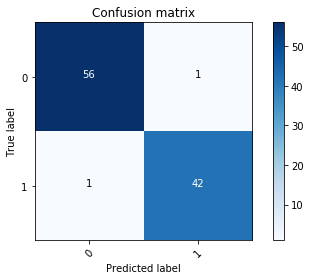

In [32]:
import itertools    
def plot_conf_mat(cm, classes, title, cmap = plt.cm.Blues):                                 
                                              
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
fig, ax = plt.subplots(figsize=(6,4))
plot_conf_mat(c_mat, classes=class_names, 
                          title='Confusion matrix')

In [33]:
for i, j in enumerate(class_names):
    print('Class {}: Predicted ratio {}%'.format(class_names[i], (c_mat[i,i]/sum(c_mat[:,i]))*100))

Class 0: Predicted ratio 98.24561403508771%
Class 1: Predicted ratio 97.67441860465115%
